In [1]:
# Import necessary libraries
import os
import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader
from collections import OrderedDict
import hydra
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf
import logging

from torch_brain.data import Dataset, collate
from torch_brain.data.sampler import RandomFixedWindowSampler
from torch_brain.models.capoyo import CaPOYO, CaPOYOTokenizer
from torch_brain.transforms import Compose
from torch_brain.utils import seed_everything
from torch_brain.utils import seed_everything, train_wrapper
from brainsets.taxonomy import decoder_registry

from tqdm import tqdm

## Loading model and relevant info

Remember to use the unfreeze snakemake rule to make sure the notebook and find it

In [2]:
# Set the environment variables and paths
ckpt_path = "/nethome/mazabou3/project_kirby/torch_brain/examples/capoyo/last.ckpt"
data_root = "/nethome/mazabou3/project_kirby/brainsets/data/processed"
config_path = "./configs/train_model_0.yaml"

In [3]:

# Initialize Hydra with the config directory
initialize(config_path="./configs")
cfg = compose(config_name="train_model_0")

seed_everything(cfg.seed)

# Higher speed on machines with tensor cores.
torch.set_float32_matmul_precision("medium")

log = logging.getLogger(__name__)

# Initialize model
model = hydra.utils.instantiate(
    cfg.model,
    decoder_specs=decoder_registry,
    _convert_="object",
)

# Prepare tokenizer and transforms
sequence_length = 1

tokenizer = CaPOYOTokenizer(
    model.unit_emb.tokenizer,
    model.session_emb.tokenizer,
    decoder_registry=decoder_registry,
    dim=model.dim_input,
    patch_size=model.patch_size,
    latent_step=cfg.get("latent_step", 1.0 / 8.0),
    num_latents_per_step=cfg.model.num_latents,
    batch_type=model.batch_type,
)

# Load datasets
train_dataset = Dataset(
    data_root,
    "train",
    include=OmegaConf.to_container(cfg.dataset),
    transform=tokenizer,
)
train_dataset.disable_data_leakage_check()

train_sampler = RandomFixedWindowSampler(
    interval_dict=train_dataset.get_sampling_intervals(),
    window_length=sequence_length,
    generator=torch.Generator().manual_seed(cfg.seed + 1),
)

/tmp/ipykernel_2601828/981309575.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="./configs")


In [4]:

#train_sampler = SequentialSampler(train_dataset)
batch_size = 128
train_loader = DataLoader(
    train_dataset,
    sampler=train_sampler,
    collate_fn=collate,
    batch_size=batch_size,
    num_workers=0,
    drop_last=True,
)

In [5]:
# Function to load model from checkpoint
def load_model_from_ckpt(model, ckpt_path):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    state_dict = ckpt["state_dict"]
    new_state_dict = OrderedDict()

    for key in state_dict.keys():
        new_key = key.removeprefix("model.")
        new_state_dict[new_key] = state_dict[key]
    # del new_state_dict["readout.projections.NATURAL_MOVIE_FRAME.weight"]
    # del new_state_dict["readout.projections.NATURAL_MOVIE_FRAME.bias"]
    model.load_state_dict(new_state_dict, strict=True)
    return model

model = load_model_from_ckpt(model, ckpt_path)
wrapper = model


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

In [7]:
device

device(type='cuda')

## Extracting latents in forward pass

getting a few different things with matching latents

Extracting latent:   0%|          | 0/2546851 [00:00<?, ?it/s]

In [8]:
def move_to_gpu(d, device):
    for k, v in d.items():
        if isinstance(v, dict):
            move_to_gpu(v, device)
        elif isinstance(v, torch.Tensor):
            d[k] = v.to(device)

In [9]:
progress_bar = tqdm(train_loader, desc="Extracting latent")

for batch in progress_bar:
    # Move all tensor-like objects in the batch to the correct device
    move_to_gpu(batch, device)
    
    # Ensure model inputs and outputs are on the same device
    model = model.to(device)  # Move the model to the correct device if it's not already there
    
    # Extract outputs and latents
    output_latents = model(**batch, stop_at_latents=True)
    
    break


Extracting latent:   0%|          | 0/19897 [00:49<?, ?it/s]


In [10]:
# Printing each key followed by its dimensions, handling non-tensor entries
for key, value in batch.items():
    if isinstance(value, torch.Tensor):  # Check if value is a tensor
        print(f"{key}: {list(value.shape)} dimensions")
    else:
        print(f"{key}: Not a tensor, skipping")

unit_index: [128, 11488] dimensions
timestamps: [128, 11488] dimensions
patches: [128, 11488, 1] dimensions
token_type: [128, 11488] dimensions
input_mask: [128, 11488] dimensions
latent_index: [128, 128] dimensions
latent_timestamps: [128, 128] dimensions
session_index: [128, 94] dimensions
output_timestamps: [128, 94] dimensions
output_decoder_index: [128, 94] dimensions
output_values: Not a tensor, skipping
output_weights: Not a tensor, skipping


In [11]:
test_batch_sess_ids = batch['session_index'].detach().cpu().numpy()

In [12]:
test_batch_sess_ids[:,0]

array([1332,  505,  124, 1201,  174,  102,  591,  788,  282,  457,  208,
        893,  175,  954,  978,  301,  495,  441,  146,  863,   89,  562,
       1012,  669, 1292,  910,  660,  613, 1010,  252,  223,  732,  501,
        320, 1173,  518, 1128,   89, 1259,    2,  736, 1274,  637, 1192,
        552,  236, 1133,  369,  428,  934,  137, 1054, 1256, 1281,  443,
        999,  517,  582, 1297,  937,  267,   99, 1039,  278,  199,   92,
        386,  464,  951,  747,  453, 1260, 1074,   43,  994,  965,  441,
       1003,  384, 1160,  520, 1201,  295,  849,  170, 1039,  926, 1056,
        329,  417,  564,  836,  426,  116,  242,  291,  950,  854,  192,
        241,  434, 1084,  614,  209,  297,  144,  419, 1142,  357, 1233,
       1206,  319,  627,  740,  640, 1269,  829,  981,  511,  183,  166,
        238, 1325,  100,  727, 1298,   85,  300])

### Extracting all latents (no labels for now)

(8,)

In [38]:
progress_bar = tqdm(train_loader, desc="Extracting latent")
count = 0
# Initialize a list to collect output_latents
# Initialize lists for all collected data
all_output_latents, session_id_all, creline_all, area_all, depth_all = [], [], [], [], []
session_index_all = []
# Use list comprehensions for efficient batch extraction
# Use list comprehensions for efficient batch extraction
for idx, batch in enumerate(progress_bar):
    move_to_gpu(batch, device)

    # Extract batch data and labels
    # curr_sess_ids = batch['session_index'].cpu().numpy()[:,0]
    # curr_crelines = batch['unit_cre_line'].cpu().numpy()[:, 0]
    # curr_area = batch['target_area'].cpu().numpy()[:, 0]
    # curr_depth = batch['unit_depth'].cpu().numpy()[:, 0]

    # session_id_all.append(curr_sess_ids)
    # creline_all.append(curr_crelines)
    # area_all.append(curr_area)
    # depth_all.append(curr_depth)

    # Ensure targets are on the correct device
    # for key in ['output_values', 'output_weights']:
    #     if key in batch:
    #         batch[key] = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch[key].items()}
    
    # Forward pass through the model
    output_latents = model(**batch, stop_at_latents=True)
    output_latents = output_latents.view(128, -1).detach().cpu().numpy() #.view(128, -1).detach().cpu().numpy()
    all_output_latents.append(output_latents)

    session_index = batch['session_index'][:, 0]
    session_index_all.append(session_index.detach().cpu().numpy())

    if idx > 1000:
        break

# Concatenate all collected data efficiently
concat = lambda x: np.concatenate(x, axis=0)
latents_all = concat(all_output_latents)
session_index_all = concat(session_index_all)
# session_id_all, creline_all, area_all, depth_all = map(concat, [session_id_all, creline_all, area_all, depth_all])

Extracting latent:   5%|▌         | 1001/19897 [10:39<3:21:10,  1.57it/s]


In [44]:
session_index_all

array([798, 864, 206, ..., 575, 697, 725])

In [47]:
model.session_emb.detokenizer(session_index_all[0])

'allen_visual_coding_ophys_2016/657786322'

In [39]:
latents_all.shape

(128256, 8192)

In [41]:
np.std(latents_all)

51.94041

In [27]:
latents_all.std(axis=1)

array([53.60811 , 61.987606, 44.56577 , ..., 45.492786, 45.96288 ,
       58.605064], dtype=float32)

In [19]:
import matplotlib.pyplot as plt

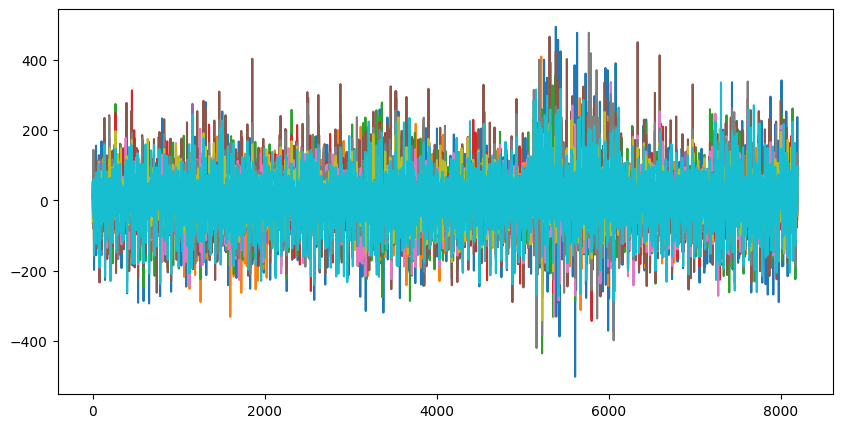

In [30]:
plt.figure(figsize=(10, 5))
for i in range(1, 1000, 100):
    plt.plot(latents_all[i])


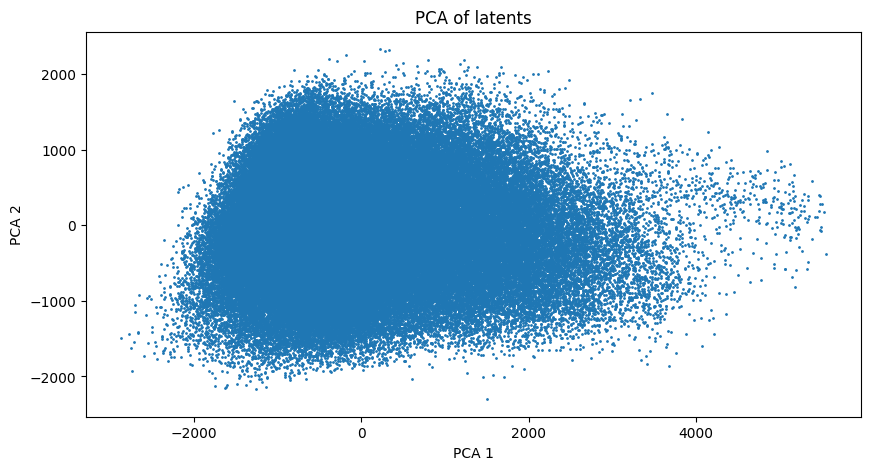

In [43]:
# apply pca and visualize the data
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_latents = pca.fit_transform(latents_all)

plt.figure(figsize=(10, 5))
plt.scatter(pca_latents[:, 0], pca_latents[:, 1], s=1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of latents')
plt.show()

In [22]:
latents_all.shape

(500096, 8192)

In [23]:
np.savez('/home/mila/x/xuejing.pan/scratch/latents/output_latents_multi_task.npz', latents_all=latents_all , session_id_all=session_id_all, creline_all=creline_all,area_all=area_all,depth_all=depth_all)

## Loading latents and processing

In [27]:
import matplotlib.pyplot as plt

# Set global font sizes
plt.rcParams['font.size'] = 16        # Global font size
plt.rcParams['axes.titlesize'] = 20   # Title font size
plt.rcParams['axes.labelsize'] = 18   # Axis label font size
plt.rcParams['xtick.labelsize'] = 18  # X-tick label font size
plt.rcParams['ytick.labelsize'] = 22  # Y-tick label font size
plt.rcParams['legend.fontsize'] = 14  # Legend font size
plt.rcParams['lines.linewidth'] = 4.5
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#662E7D'])


In [1]:
import numpy as np

In [2]:
data = np.load('/home/mila/x/xuejing.pan/scratch/latents/output_latents_multi_task.npz')

# Extract the numpy array
all_latents = data['latents_all']
session_id_all = data['session_id_all']
creline_all = data['creline_all']
area_all = data['area_all']
depth_all = data['depth_all']

del data


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_all_latents = scaler.fit_transform(all_latents)

In [4]:
all_latents.shape

(500096, 8192)

In [22]:

# Define the bin edges for the depth ranges
bins = [0, 250, 350, 500, np.inf]

# Map the values of depth_all to the corresponding integer classes
# 0 -> L2/3, 1 -> L4, 2 -> L5, 3 -> L6
depth_all_classes = np.digitize(depth_all, bins) - 1  # digitize returns bin indices starting from 1

# Create a dictionary to map integer classes to string labels
depth_map = {0: "L2/3", 1: "L4", 2: "L5", 3: "L6"}

# Map depth values to string labels using the class indices
#class_labels = np.array([depth_map[i] for i in depth_all_classes])


In [23]:
depth_all

array([275, 175, 275, ..., 350, 275, 175])

In [24]:
depth_all_classes

array([1, 0, 1, ..., 2, 1, 0])

## Dendrogram

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [20]:
creline_map = {
    0: "Cux2",
    1: "Exm1",
    2: "Fezf2",
    3: "Nr5a1",
    4: "Ntsr1",
    5: "Pvalb",
    6: "Rbp4",
    7: "Rorb",
    8: "Scnn1a",
    9: "Slc17a7",
    10: "Sst",
    11: "Tlx3",
    12: "Vip"
}

# Create a dictionary to map integer classes to string labels
depth_map = {0: "L2/3", 1: "L4", 2: "L5", 3: "L6"}

area_map = {
    0: "RL", 
    1: "PM",
    2: "AL",
    3: "AM",
    4: "P",
    5: "L"
}


In [25]:

# Dictionary to store the average latents for each creline and depth combination
average_latents = {}

# Get unique creline values
unique_crelines = np.unique(creline_all)

# Loop through each creline
for creline in unique_crelines:
    # Get the indices for this creline
    creline_indices = np.where(creline_all == creline)[0]
    
    # If creline == 1 or creline == 9, further divide based on depth
    if creline == 1 or creline == 9:
        unique_depths = np.unique(depth_all_classes[creline_indices])
        for depth in unique_depths:
            depth_indices = creline_indices[depth_all_classes[creline_indices] == depth]
            avg_latent = np.mean(all_latents[depth_indices], axis=0)
            average_latents[(creline, depth)] = avg_latent
    else:
        # For other crelines, calculate the average directly
        avg_latent = np.mean(all_latents[creline_indices], axis=0)
        average_latents[creline] = avg_latent

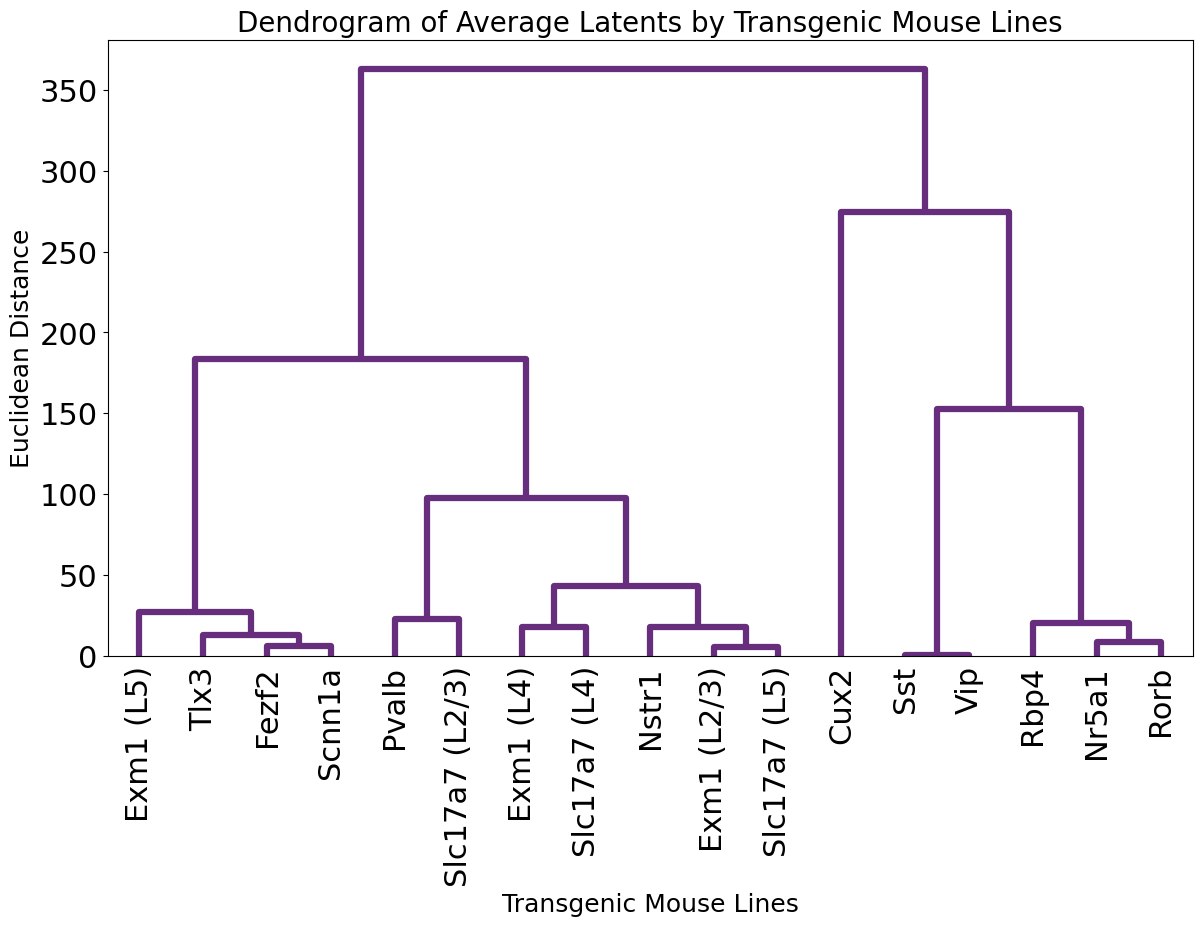

In [29]:
# Assuming `average_latents` is your dictionary with creline (or creline, depth) as keys and average latents as values
keys = list(average_latents.keys())
avg_latent_values = np.array([average_latents[key] for key in keys])

# Replace creline and depth values in the keys with the corresponding names from creline_map and depth_map
def format_label(key):
    if isinstance(key, tuple):  # For (creline, depth) keys
        creline_label = creline_map[key[0]]
        depth_label = depth_map[key[1]]
        return f"{creline_label} ({depth_label})"
    else:  # For single creline keys
        return creline_map[key]

# Apply the label formatting function to all keys
formatted_labels = [format_label(key) for key in keys]

# Step 1: Standardize the data
scaler = StandardScaler()
avg_latent_scaled = scaler.fit_transform(avg_latent_values)

# Step 2: Perform hierarchical clustering using the linkage function
Z = linkage(avg_latent_scaled, method='ward')

# Step 3: Plot the dendrogram with the new labels
plt.figure(figsize=(14, 8))
dendrogram(Z, labels=formatted_labels, leaf_rotation=90, leaf_font_size=22, show_leaf_counts=True,)#  above_threshold_color='#F9B40D')
plt.title('Dendrogram of Average Latents by Transgenic Mouse Lines')
plt.xlabel('Transgenic Mouse Lines')
plt.ylabel('Euclidean Distance')
plt.show()

# Old stuff

## Loading latent for analysis and reducing dims

In [13]:

# Load the .npz file
data = np.load('/home/mila/x/xuejing.pan/scratch/latents/output_latents.npz')

# Extract the numpy array
all_latents = data['all_latents'][::3]
df_labels_all = data['df_labels_all'][::3]
session_id_all = data['session_id_all'][::3]
creline_all = data['creline_all'][::3]
area_all = data['area_all'][::3]
depth_all = data['depth_all'][::3]

correct_latents=data['correct_latents'][::3]
correct_session_ids_all = data['correct_session_ids_all'][::3]
correct_labels_all = data['correct_labels_all'][::3]
correct_creline_all = data['correct_creline_all'][::3]
correct_area_all = data['correct_area_all'][::3]
correct_depth_all = data['correct_depth_all'][::3]

del data
# Print the shape of the loaded array to verify
print(all_latents.shape)

(128, 8192)


In [3]:
area_all.shape

(112299,)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_correct_latents = scaler.fit_transform(correct_latents)
normalized_all_latents = scaler.fit_transform(all_latents)

#diwnsampling by a factor of 3
normalized_correct_latents = normalized_correct_latents
normalized_all_latents = normalized_all_latents

In [5]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# If using PCA
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

import umap

PCA

In [5]:
# Perform PCA
pca = PCA(n_components=3)
all_latents_pca = pca.fit_transform(normalized_all_latents)
# Perform PCA
pca = PCA(n_components=3)
correct_latent_pca = pca.fit_transform(normalized_correct_latents)

UMAP

In [17]:

umap_model = umap.UMAP(n_components=3,n_jobs=-1, verbose=True,n_epochs=500, n_neighbors=260)

# Fit and transform your data
all_latents_umap = umap_model.fit_transform(normalized_all_latents)
#np.savez('/home/mila/x/xuejing.pan/scratch/latents/umap_reduced.npz', all_latents_umap)

correct_latents_umap = umap_model.fit_transform(normalized_correct_latents)
#np.savez('/home/mila/x/xuejing.pan/scratch/latents/umap_reduced_correct.npz',  correct_latents_umap)

UMAP(n_components=3, n_epochs=500, n_neighbors=260, verbose=True)
Sun Aug  4 21:14:00 2024 Construct fuzzy simplicial set
Sun Aug  4 21:14:21 2024 Finding Nearest Neighbors
Sun Aug  4 21:14:22 2024 Building RP forest with 22 trees
Sun Aug  4 21:15:17 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	 8  /  17
	 9  /  17
	 10  /  17
	 11  /  17
	Stopping threshold met -- exiting after 11 iterations
Sun Aug  4 21:21:58 2024 Finished Nearest Neighbor Search
Sun Aug  4 21:22:34 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Aug  4 21:32:04 2024 Finished embedding
UMAP(n_components=3, n_epochs=500, n_neighbors=260, verbose=True)
Sun Aug  4 21:32:55 2024 Construct fuzzy simplicial set
Sun Aug  4 21:34:34 2024 Finding Nearest Neighbors
Sun Aug  4 21:34:34 2024 Building RP forest with 16 trees
Sun Aug  4 21:34:50 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	 8  /  16
	 9  /  16
	Stopping threshold met -- exiting after 9 iterations
Sun Aug  4 21:37:30 2024 Finished Nearest Neighbor Search
Sun Aug  4 21:38:32 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Aug  4 21:42:24 2024 Finished embedding


TSNE

In [6]:
# Run t-SNE with the callback
tsne = TSNE(n_iter=10000, n_jobs=16, verbose=2, n_components=3, perplexity=100.0)
correct_latents_tsne = tsne.fit_transform(correct_latent_pca)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 46759 samples in 0.003s...
[t-SNE] Computed neighbors for 46759 samples in 2.027s...
[t-SNE] Computed conditional probabilities for sample 1000 / 46759
[t-SNE] Computed conditional probabilities for sample 2000 / 46759
[t-SNE] Computed conditional probabilities for sample 3000 / 46759
[t-SNE] Computed conditional probabilities for sample 4000 / 46759
[t-SNE] Computed conditional probabilities for sample 5000 / 46759
[t-SNE] Computed conditional probabilities for sample 6000 / 46759
[t-SNE] Computed conditional probabilities for sample 7000 / 46759
[t-SNE] Computed conditional probabilities for sample 8000 / 46759
[t-SNE] Computed conditional probabilities for sample 9000 / 46759
[t-SNE] Computed conditional probabilities for sample 10000 / 46759
[t-SNE] Computed conditional probabilities for sample 11000 / 46759
[t-SNE] Computed conditional probabilities for sample 12000 / 46759
[t-SNE] Computed conditional probabilities for sa

In [7]:
tsne = TSNE(n_iter=10000, n_jobs=16, verbose=2, n_components=3, perplexity=100.0)
all_latents_tsne = tsne.fit_transform(all_latents_pca[::3])

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 37433 samples in 0.003s...
[t-SNE] Computed neighbors for 37433 samples in 1.266s...
[t-SNE] Computed conditional probabilities for sample 1000 / 37433
[t-SNE] Computed conditional probabilities for sample 2000 / 37433
[t-SNE] Computed conditional probabilities for sample 3000 / 37433
[t-SNE] Computed conditional probabilities for sample 4000 / 37433
[t-SNE] Computed conditional probabilities for sample 5000 / 37433
[t-SNE] Computed conditional probabilities for sample 6000 / 37433
[t-SNE] Computed conditional probabilities for sample 7000 / 37433
[t-SNE] Computed conditional probabilities for sample 8000 / 37433
[t-SNE] Computed conditional probabilities for sample 9000 / 37433
[t-SNE] Computed conditional probabilities for sample 10000 / 37433
[t-SNE] Computed conditional probabilities for sample 11000 / 37433
[t-SNE] Computed conditional probabilities for sample 12000 / 37433
[t-SNE] Computed conditional probabilities for sa

In [8]:
# Save the numpy array to a .npz file
np.savez('/home/mila/x/xuejing.pan/scratch/latents/tsne_reduced.npz', correct_latents_tsne=correct_latents_tsne, all_latents_tsne=all_latents_tsne)

## Hierarchical clustering

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
creline_map = {
    0: "CUX2",
    1: "EXM1_IRES_CRE",
    2: "FEZF2_CREER",
    3: "NR5A1_CRE",
    4: "NTSR1_CRE_GN220",
    5: "PVALB_IRES_CRE",
    6: "RBP4_CRE_KL100",
    7: "RORB_IRES2_CRE",
    8: "SCNN1A_TG3_CRE",
    9: "SLC17A7_IRES2_CRE",
    10: "SST_IRES_CRE",
    11: "TLX3_CRE_PL56",
    12: "VIP_IRES_CRE"
}


area_map = {
    0: "RL", 
    1: "PM",
    2: "AL",
    3: "AM",
    4: "P",
    5: "L"
}


### correct latents

In [4]:
# Get the unique cre lines
crelines = np.unique(correct_creline_all)

# Average latents for each cre line
creline_averages = []
for creline in crelines:
    # Select latents corresponding to the current cre line
    latents_for_creline = correct_latents[correct_creline_all == creline]
    
    # Compute the average latents for the current cre line
    avg_latents = np.mean(latents_for_creline, axis=0)
    creline_averages.append(avg_latents)

In [5]:
# Convert the list to a numpy array
creline_averages = np.array(creline_averages)
print(creline_averages.shape)

(13, 8192)


In [8]:
# Standardize the latents before clustering (this is often recommended)
scaler = StandardScaler()
creline_averages_scaled = scaler.fit_transform(creline_averages)


In [9]:
# Perform hierarchical clustering
Z = linkage(creline_averages_scaled, method='ward')  # you can choose other methods as well


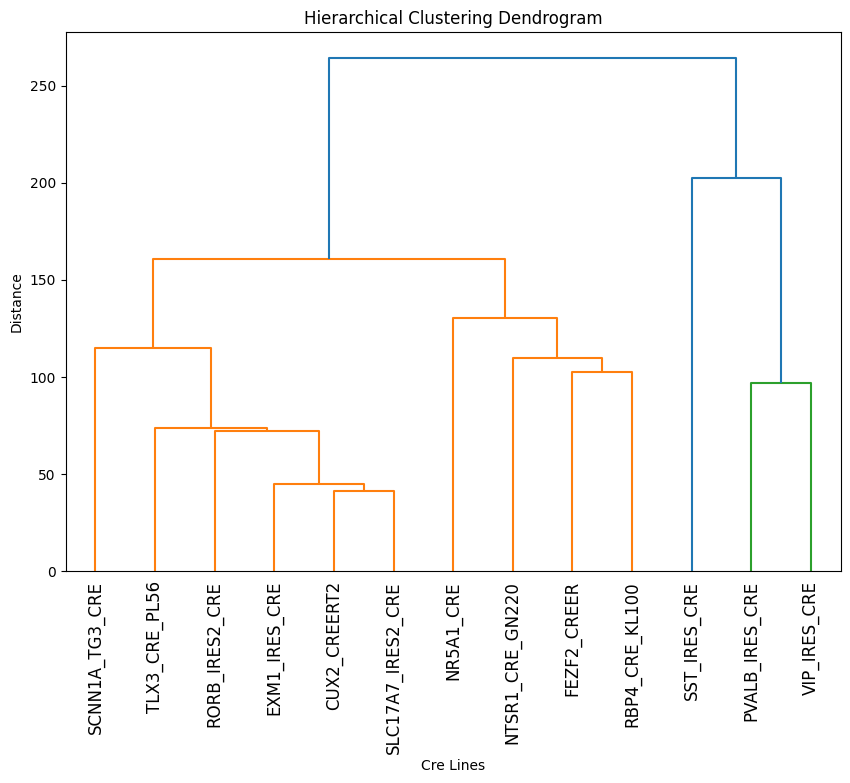

In [15]:

# Map creline indices to labels using creline_map
creline_labels = [creline_map[int(creline)] for creline in crelines]

plt.figure(figsize=(10, 7))
dendrogram(Z, labels=creline_labels, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cre Lines')
plt.ylabel('Distance')
plt.show()

### all latents

In [15]:
# Get the unique cre lines
crelines = np.unique(creline_all)

# Average latents for each cre line
creline_averages = []
for creline in crelines:
    #if creline == 0 or creline == 1 or creline == 9 or creline == 5 or creline == 10 or creline == 12:
    #    continue
    # Select latents corresponding to the current cre line
    latents_for_creline = all_latents[creline_all == creline]
    
    # Compute the average latents for the current cre line
    avg_latents = np.mean(latents_for_creline, axis=0)
    creline_averages.append(avg_latents)

In [16]:

# Get the unique cre lines
crelines = np.unique(creline_all)

# Initialize list to store creline averages and sample counts
creline_averages = []
creline_sample_counts = []

for creline in crelines:
    # Select latents corresponding to the current cre line
    latents_for_creline = all_latents[creline_all == creline]
    
    # Compute the average latents for the current cre line
    avg_latents = np.mean(latents_for_creline, axis=0)
    
    # Count the number of samples for the current cre line
    sample_count = latents_for_creline.shape[0]
    
    # Append the results
    creline_averages.append(avg_latents)
    creline_sample_counts.append(sample_count)

In [17]:
# Convert the list to a numpy array
creline_averages = np.array(creline_averages)
print(creline_averages.shape)

(13, 8192)


In [18]:
# Standardize the latents before clustering (this is often recommended)
scaler = StandardScaler()
creline_averages_scaled = scaler.fit_transform(creline_averages)


In [19]:
Z = linkage(creline_averages_scaled, method='ward')  # you can choose other methods as well
leaves_order = leaves_list(Z)


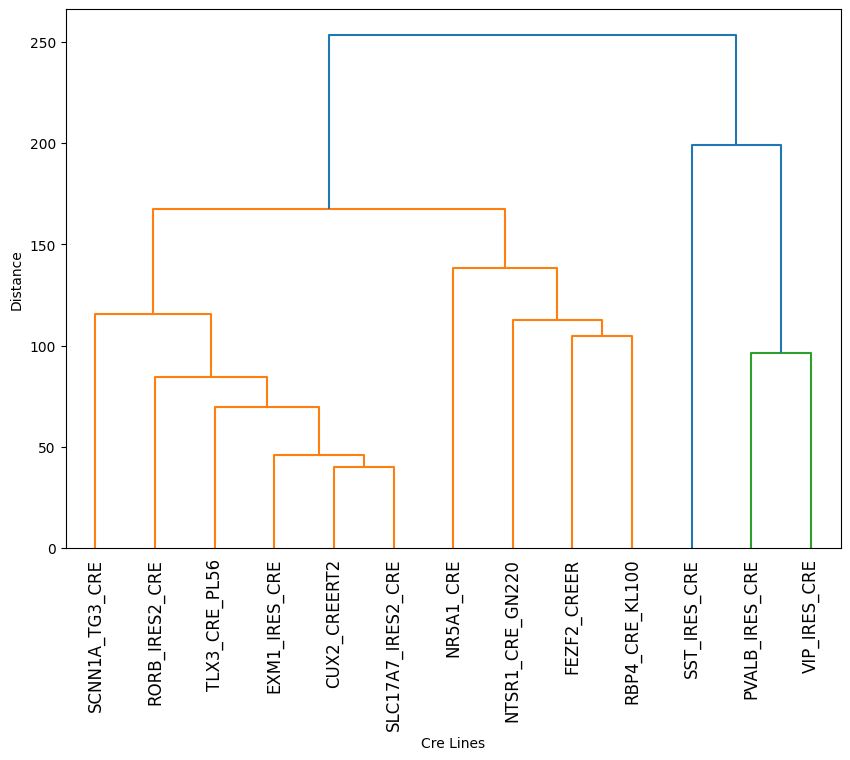

In [21]:
creline_map = {
    0: "CUX2_CREERT2",
    1: "EXM1_IRES_CRE",
    2: "FEZF2_CREER",
    3: "NR5A1_CRE",
    4: "NTSR1_CRE_GN220",
    5: "PVALB_IRES_CRE",
    6: "RBP4_CRE_KL100",
    7: "RORB_IRES2_CRE",
    8: "SCNN1A_TG3_CRE",
    9: "SLC17A7_IRES2_CRE",
    10: "SST_IRES_CRE",
    11: "TLX3_CRE_PL56",
    12: "VIP_IRES_CRE"
}

#excluded_values = {0, 1, 5, 10, 12, 9}  # replace value1, value2, etc. with the actual values


# Map creline indices to labels using creline_map
creline_labels = [creline_map[int(creline)] for creline in crelines]

# Filter out the excluded values from crelines and map the remaining ones to labels
#creline_labels = [creline_map[int(creline)] for creline in crelines if int(creline) not in excluded_values]

plt.figure(figsize=(10, 7))
dendrogram(Z, labels=creline_labels, leaf_rotation=90)
#dendrogram(Z, labels=np.array(creline_labels)[leaves_order], leaf_rotation=90)
#plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cre Lines')
plt.ylabel('Distance')
plt.show()


In [22]:
ordered_sample_counts = np.array(creline_sample_counts)[leaves_order]

# Print the sample sizes in the order of the dendrogram
for label, count in zip(np.array(creline_labels)[leaves_order], ordered_sample_counts):
    print(f'{label}: {count} samples')

SCNN1A_TG3_CRE: 1929 samples
RORB_IRES2_CRE: 10314 samples
TLX3_CRE_PL56: 1940 samples
EXM1_IRES_CRE: 10303 samples
CUX2_CREERT2: 18242 samples
SLC17A7_IRES2_CRE: 13923 samples
NR5A1_CRE: 9607 samples
NTSR1_CRE_GN220: 4429 samples
FEZF2_CREER: 1384 samples
RBP4_CRE_KL100: 9970 samples
SST_IRES_CRE: 12642 samples
PVALB_IRES_CRE: 4770 samples
VIP_IRES_CRE: 12846 samples


In [10]:
creline_sample_counts

[18242,
 10303,
 1384,
 9607,
 4429,
 4770,
 9970,
 10314,
 1929,
 13923,
 12642,
 1940,
 12846]

### creline + brain region + depth

In [10]:
creline_map = {
    0: "CUX2_CREERT2",
    1: "EXM1_IRES_CRE",
    2: "FEZF2_CREER",
    3: "NR5A1_CRE",
    4: "NTSR1_CRE_GN220",
    5: "PVALB_IRES_CRE",
    6: "RBP4_CRE_KL100",
    7: "RORB_IRES2_CRE",
    8: "SCNN1A_TG3_CRE",
    9: "SLC17A7_IRES2_CRE",
    10: "SST_IRES_CRE",
    11: "TLX3_CRE_PL56",
    12: "VIP_IRES_CRE"
}

depth_map = {
    0: "150-250 um",
    1: "250-350 um",
    2: "350-500 um",
    3: "500-600 um",
    4: "600+ um"
}

area_map = {
    0: "VIS_RL", 
    1: "VIS_PM",
    2: "VIS_AL",
    3: "VIS_AM",
    4: "VIS_P",
    5: "VIS_L"
}


In [13]:
# Combine the three labels into a single composite label
composite_labels = [(creline_all[i], area_all[i], depth_all[i]) for i in range(len(creline_all))]

# Get unique combinations of the composite labels
unique_combinations = list(set(composite_labels))

# Average latents for each unique combination of the three labels
composite_averages = []
composite_labels_names = []


In [15]:
for combination in unique_combinations:
    # Select latents corresponding to the current combination
    indices = [i for i in range(len(composite_labels)) if composite_labels[i] == combination]
    latents_for_combination = all_latents[indices]
    
    # Compute the average latents for the current combination
    avg_latents = np.mean(latents_for_combination, axis=0)
    composite_averages.append(avg_latents)
    
    # Generate a meaningful label for this combination
    creline_name = creline_map[combination[0]]
    area_name = area_map[combination[1]]
    depth_name = depth_map[combination[2]]
    composite_labels_names.append(f"{creline_name} | {area_name} | {depth_name}")

# Convert the list to a numpy array
composite_averages = np.array(composite_averages)


In [17]:
composite_averages.shape

(88, 8192)

In [18]:
# Standardize the latents before clustering
scaler = StandardScaler()
composite_averages_scaled = scaler.fit_transform(composite_averages)

# Perform hierarchical clustering
Z = linkage(composite_averages_scaled, method='ward')  # you can choose other methods as well


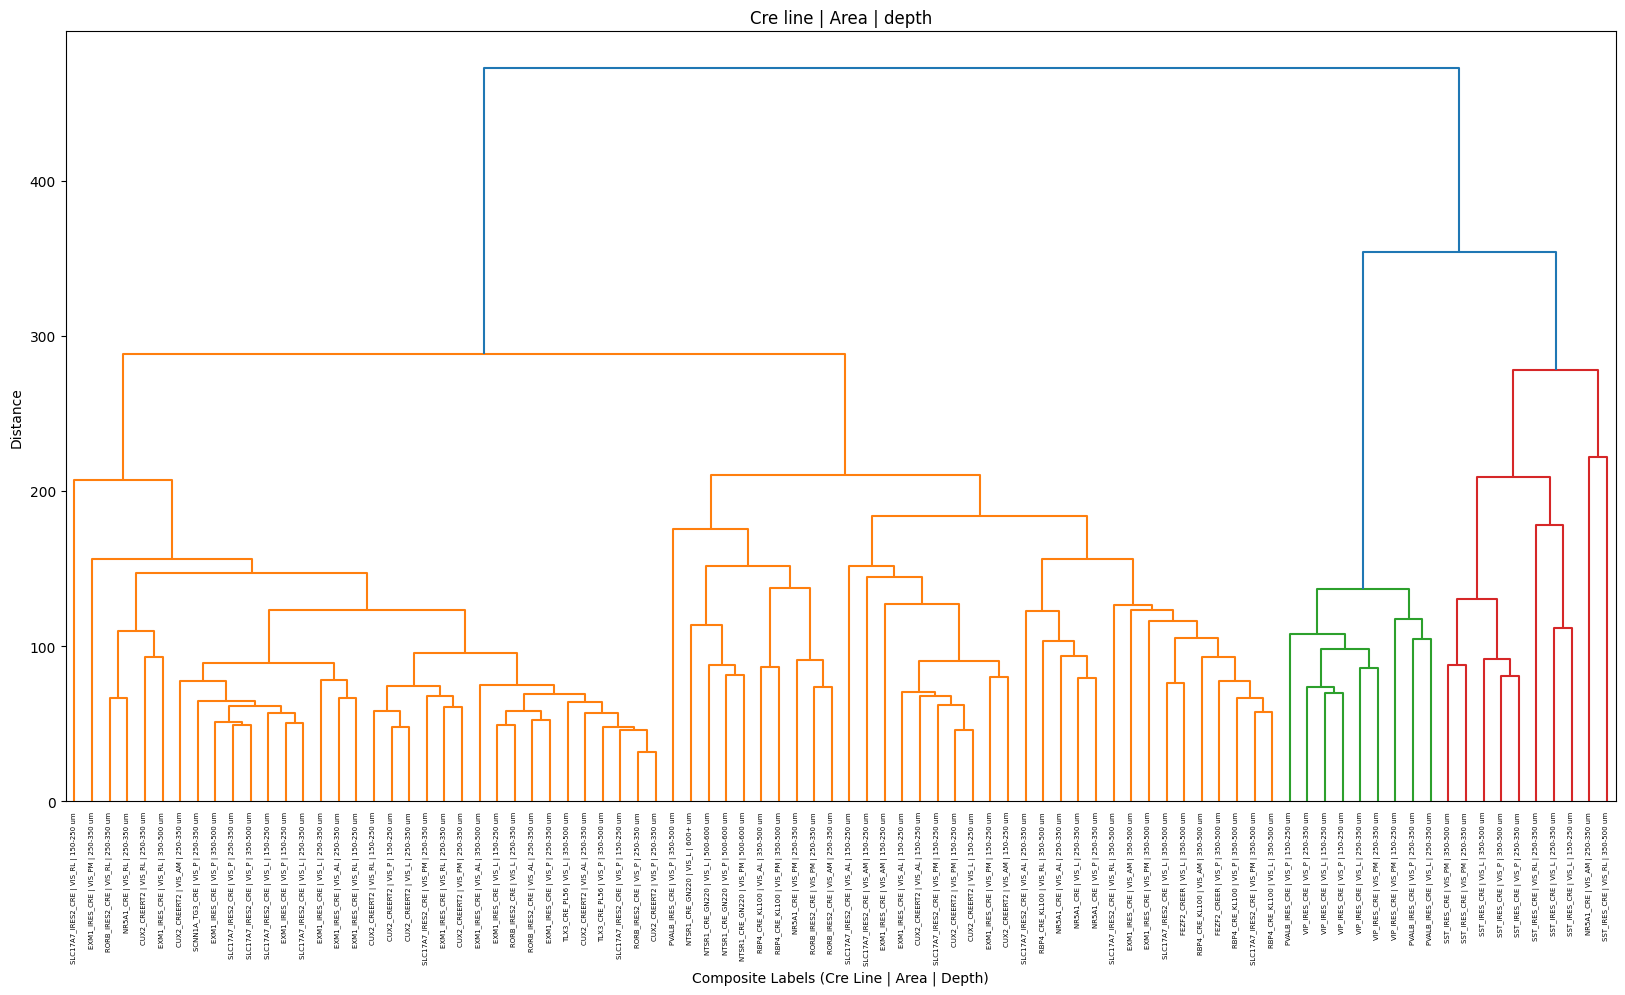

In [21]:
# Plot the dendrogram
plt.figure(figsize=(20, 10))
dendrogram(Z, labels=composite_labels_names, leaf_rotation=90)
plt.title('Cre line | Area | depth')
plt.xlabel('Composite Labels (Cre Line | Area | Depth)')
plt.ylabel('Distance')
plt.show()


### Creline + brain region

In [25]:

# Combine the two labels into a single composite label
composite_labels = [(creline_all[i], area_all[i]) for i in range(len(creline_all))]

# Get unique combinations of the composite labels
unique_combinations = list(set(composite_labels))

# Average latents for each unique combination of the two labels
composite_averages = []
composite_labels_names = []

for combination in unique_combinations:
    # Select latents corresponding to the current combination
    indices = [i for i in range(len(composite_labels)) if composite_labels[i] == combination]
    latents_for_combination = all_latents[indices]
    
    # Compute the average latents for the current combination
    avg_latents = np.mean(latents_for_combination, axis=0)
    composite_averages.append(avg_latents)
    
    # Generate a meaningful label for this combination
    creline_name = creline_map[combination[0]]
    area_name = area_map[combination[1]]
    composite_labels_names.append(f"{creline_name} | {area_name}")

# Convert the list to a numpy array
composite_averages = np.array(composite_averages)

# Standardize the latents before clustering
scaler = StandardScaler()
composite_averages_scaled = scaler.fit_transform(composite_averages)

# Perform hierarchical clustering
Z = linkage(composite_averages_scaled, method='ward')  # you can choose other methods as well


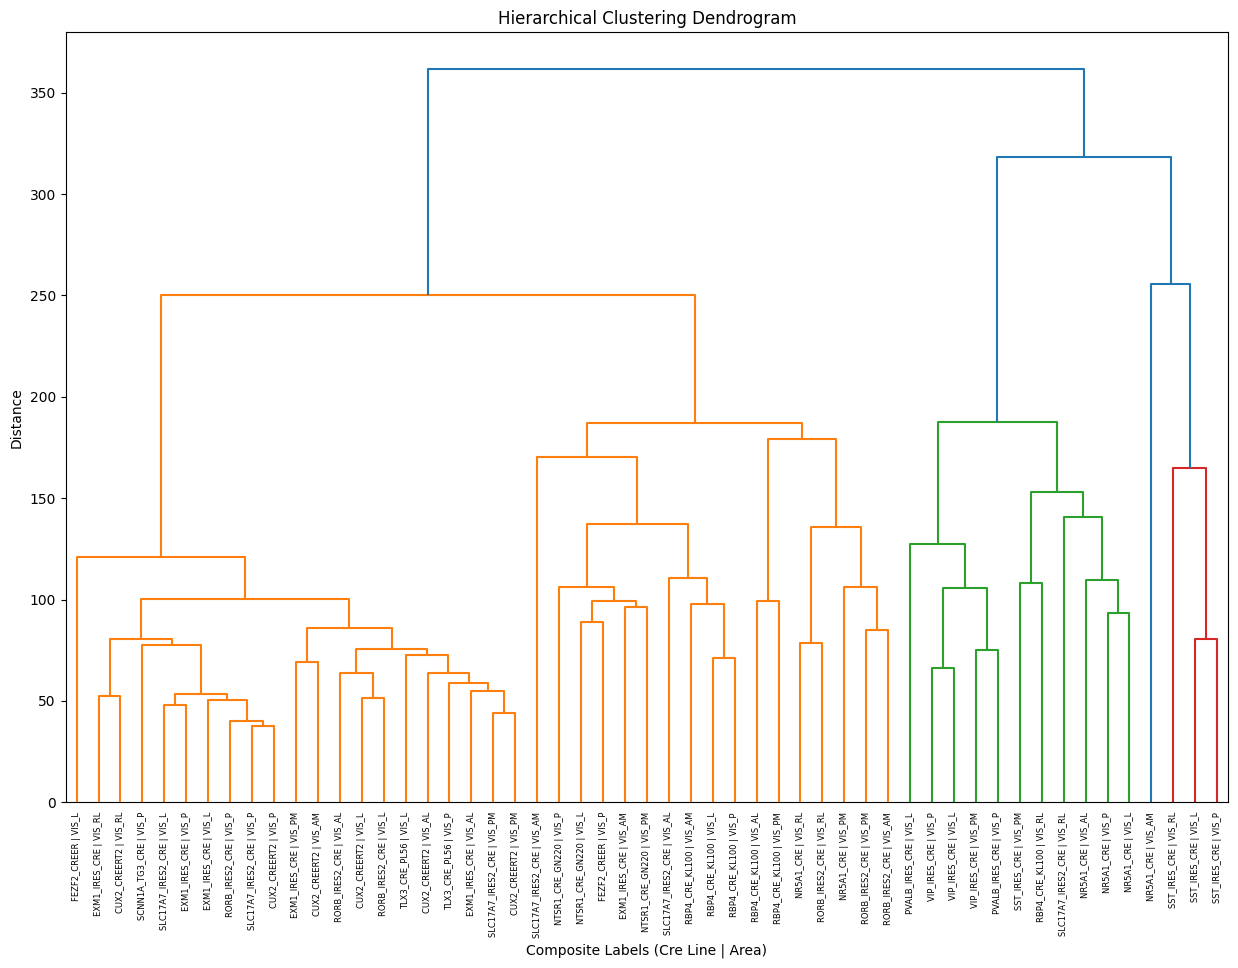

In [26]:
# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(Z, labels=composite_labels_names, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Composite Labels (Cre Line | Area)')
plt.ylabel('Distance')
plt.show()

### Creline + depth

In [13]:
composite_labels = [(creline_all[i], depth_all[i]) for i in range(len(creline_all))]
unique_combinations = list(set(composite_labels))

In [20]:

# Average latents for each unique combination of the two labels
composite_averages = []
composite_labels_names = []

for combination in unique_combinations:
    # Select latents corresponding to the current combination
    indices = [i for i in range(len(composite_labels)) if composite_labels[i] == combination]
    latents_for_combination = all_latents[indices]
    
    # Compute the average latents for the current combination
    avg_latents = np.mean(latents_for_combination, axis=0)
    composite_averages.append(avg_latents)
    
    # Generate a meaningful label for this combination
    creline_name = creline_map[combination[0]]
    depth_name = depth_map[combination[1]]
    composite_labels_names.append(f"{creline_name} | {depth_name}")

# Convert the list to a numpy array
composite_averages = np.array(composite_averages)

# Standardize the latents before clustering
scaler = StandardScaler()
composite_averages_scaled = scaler.fit_transform(composite_averages)

# Perform hierarchical clustering
Z = linkage(composite_averages_scaled, method='ward')  # you can choose other methods as well


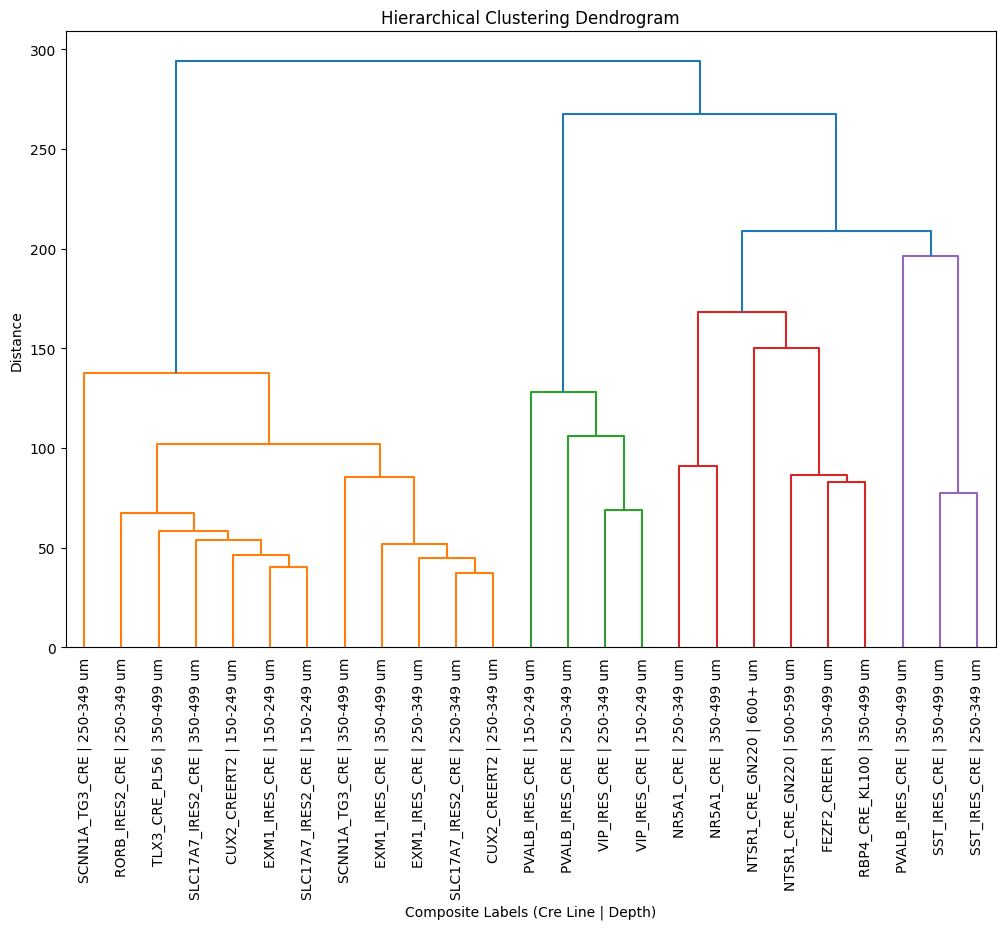

In [21]:
# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z, labels=composite_labels_names, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Composite Labels (Cre Line | Depth)')
plt.ylabel('Distance')
plt.show()

### Areas

In [24]:

# Get the unique cre lines
areas = np.unique(area_all)

# Initialize list to store creline averages and sample counts
area_averages = []
area_sample_counts = []

for area in areas:
    # Select latents corresponding to the current cre line
    latents_for_area = all_latents[area_all == area]
    
    # Compute the average latents for the current cre line
    avg_latents = np.mean(latents_for_area, axis=0)
    
    # Count the number of samples for the current cre line
    sample_count = latents_for_area.shape[0]
    
    # Append the results
    area_averages.append(avg_latents)
    area_sample_counts.append(sample_count)

In [25]:
area_averages = np.array(area_averages)
# Standardize the latents before clustering (this is often recommended)
scaler = StandardScaler()
area_averages_scaled = scaler.fit_transform(area_averages)

In [26]:
Z = linkage(area_averages_scaled, method='ward')  # you can choose other methods as well
leaves_order = leaves_list(Z)


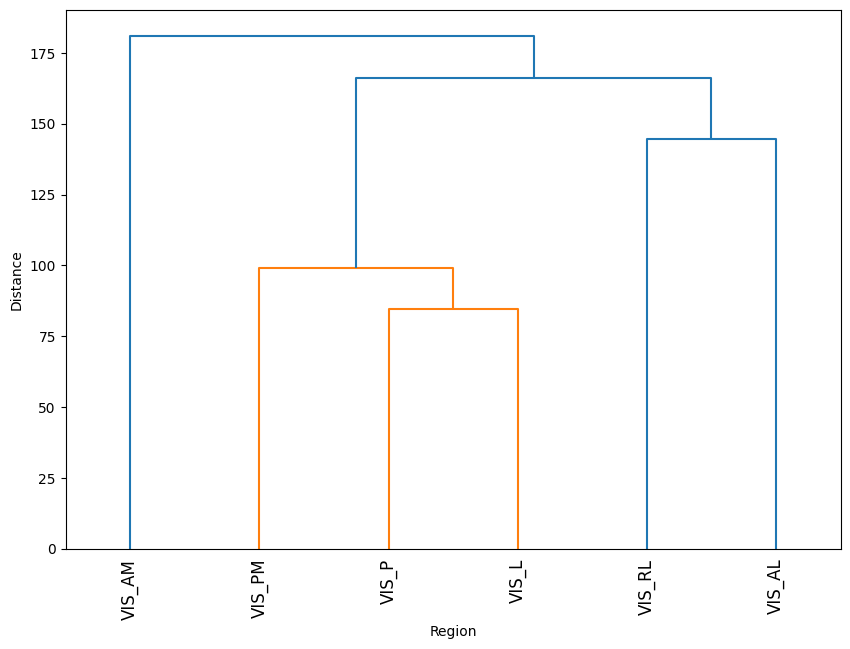

In [28]:


# Map creline indices to labels using creline_map
area_labels = [area_map[int(area)] for area in areas]

# Filter out the excluded values from crelines and map the remaining ones to labels
#creline_labels = [creline_map[int(creline)] for creline in crelines if int(creline) not in excluded_values]

plt.figure(figsize=(10, 7))
dendrogram(Z, labels=area_labels, leaf_rotation=90)
#dendrogram(Z, labels=np.array(creline_labels)[leaves_order], leaf_rotation=90)
#plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Region')
plt.ylabel('Distance')
plt.show()


In [29]:
ordered_sample_counts = np.array(area_sample_counts)[leaves_order]

# Print the sample sizes in the order of the dendrogram
for label, count in zip(np.array(area_labels)[leaves_order], ordered_sample_counts):
    print(f'{label}: {count} samples')

VIS_AM: 9268 samples
VIS_PM: 22956 samples
VIS_P: 34136 samples
VIS_L: 25569 samples
VIS_RL: 10784 samples
VIS_AL: 9586 samples


## Plotting
Plotting into html files directory for downloading and viewing

In [6]:
import plotly.graph_objects as go
import plotly.express as px

In [7]:
mapping = {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 2, 6: 1, 7: 1, 8: 1, 9: 0, 10: 2, 11: 1, 12: 2}
creline_type_all = np.array([mapping[label] for label in creline_all])
creline_type_correct=np.array([mapping[label] for label in correct_creline_all])

In [8]:
data = np.load('/home/mila/x/xuejing.pan/scratch/latents/umap_reduced.npz')
print(data.files)
all_latents_umap = data['arr_0']
data = np.load('/home/mila/x/xuejing.pan/scratch/latents/umap_reduced_correct.npz')
correct_latents_umap = data['arr_0']

['arr_0']


In [3]:
data =np.load('/home/mila/x/xuejing.pan/scratch/latents/tsne_reduced.npz')
all_latents_tsne = data['all_latents_tsne']
correct_latents_tsne = data['correct_latents_tsne']

In [10]:
def create_3d_scatter_plot(normalized_all_latents_pca, session_id_all, tsne_all=False):
    if tsne_all:
        normalized_all_latents_pca = normalized_all_latents_pca[::3]
        session_id_all = session_id_all[::3]
    
    # Create DataFrame
    df = pd.DataFrame({
        'x': normalized_all_latents_pca[:, 0],
        'y': normalized_all_latents_pca[:, 1],
        'z': normalized_all_latents_pca[:, 2],
        'session': session_id_all
    })

    # Ensure that 'session' is treated as a categorical variable
    df['session'] = df['session'].astype(str)

    # Create the 3D scatter plot with smaller markers
    fig = px.scatter_3d(df, x='x', y='y', z='z', color='session', title='3D Scatter Plot of Sessions')
    fig.update_traces(marker=dict(size=1))  # Adjust the size to make markers smaller

    # Save the figure as an HTML file
    #fig.write_html("all_latent_pca_sessions.html")

    return fig

In [11]:
correct_latents_tsne.shape

(46759, 3)

In [12]:
correct_area_all.shape

(46759,)

In [14]:
create_3d_scatter_plot(correct_latent_pca,correct_area_all).write_html("correct_latents_pca_area.html")

## Linear probe for brain region

In [5]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:

# Assuming latents are in a numpy array or tensor named 'all_latents' and labels are in 'area_all'
all_latents = torch.tensor(normalized_all_latents, dtype=torch.float32)
area_all = torch.tensor(area_all, dtype=torch.long)
# Parameters
num_runs = 3
num_epochs = 50
batch_size = 256
learning_rate = 0.001

# Define the model class again for completeness
class LinearProbe(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Average tracking variables
total_val_accuracy = 0.0
total_val_loss = 0.0
total_confusion_matrix = None

# Run the process multiple times
for run in range(num_runs):
    print(f"Run {run+1}/{num_runs}")
    
    # Create a new dataset split for each run to account for randomness
    dataset = TensorDataset(all_latents, area_all)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize a new model, loss function, and optimizer for each run
    num_classes = len(torch.unique(area_all))
    input_dim = all_latents.shape[1]
    model = LinearProbe(input_dim=input_dim, output_dim=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    
    # Validation with accuracy and confusion matrix
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    val_loss /=len(val_loader)
    total_val_accuracy += accuracy
    total_val_loss += val_loss
    
    # Compute confusion matrix for this run
    cm = confusion_matrix(all_labels, all_preds)
    
    if total_confusion_matrix is None:
        total_confusion_matrix = cm
    else:
        total_confusion_matrix += cm

# Average the results over all runs
average_val_accuracy = total_val_accuracy / num_runs
average_val_loss = total_val_loss / num_runs
average_confusion_matrix = total_confusion_matrix / num_runs

# Normalize confusion matrix to percentages
cm_percentage = average_confusion_matrix / average_confusion_matrix.sum(axis=1, keepdims=True) * 100


Run 1/3
Epoch 1/50, Loss: 21.051608968664098
Epoch 2/50, Loss: 12.316422224724056
Epoch 3/50, Loss: 11.732395488652068
Epoch 4/50, Loss: 12.04985761370754
Epoch 5/50, Loss: 11.78848853478065
Epoch 6/50, Loss: 12.535781647065427
Epoch 7/50, Loss: 11.710915895608755
Epoch 8/50, Loss: 13.017461793035524
Epoch 9/50, Loss: 12.09721951199393
Epoch 10/50, Loss: 12.187879696870462
Epoch 11/50, Loss: 11.7252303759257
Epoch 12/50, Loss: 11.910253269380314
Epoch 13/50, Loss: 12.340463248413172
Epoch 14/50, Loss: 12.79265447219892
Epoch 15/50, Loss: 12.539844415126703
Epoch 16/50, Loss: 12.425197117688649
Epoch 17/50, Loss: 12.733455302029254
Epoch 18/50, Loss: 12.421068493117634
Epoch 19/50, Loss: 12.920609042175816
Epoch 20/50, Loss: 13.178185467027191
Epoch 21/50, Loss: 12.37861017623858
Epoch 22/50, Loss: 12.647611634344118
Epoch 23/50, Loss: 12.415486430850125
Epoch 24/50, Loss: 12.680251986892134
Epoch 25/50, Loss: 12.636741333877259
Epoch 26/50, Loss: 12.595961239263204
Epoch 27/50, Loss: 1

Average Validation Cross Entropy Loss: 32.1494
Average Validation Accuracy: 60.93%


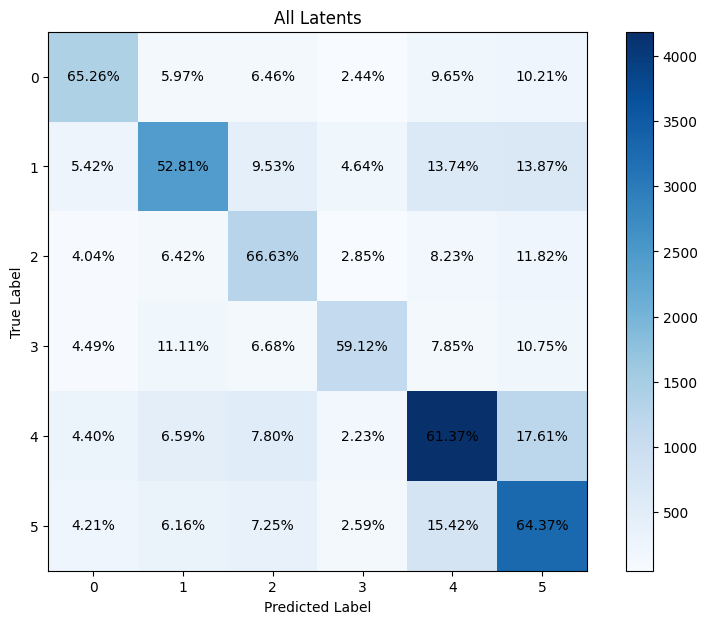

In [5]:

# Print average results
print(f"Average Validation Cross Entropy Loss: {average_val_loss:.4f}")
print(f"Average Validation Accuracy: {average_val_accuracy * 100:.2f}%")

# Plot the averaged confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(average_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('All Latents')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add percentage labels to the confusion matrix
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f'{cm_percentage[i, j]:.2f}%', ha='center', va='center', color='black')

plt.show()

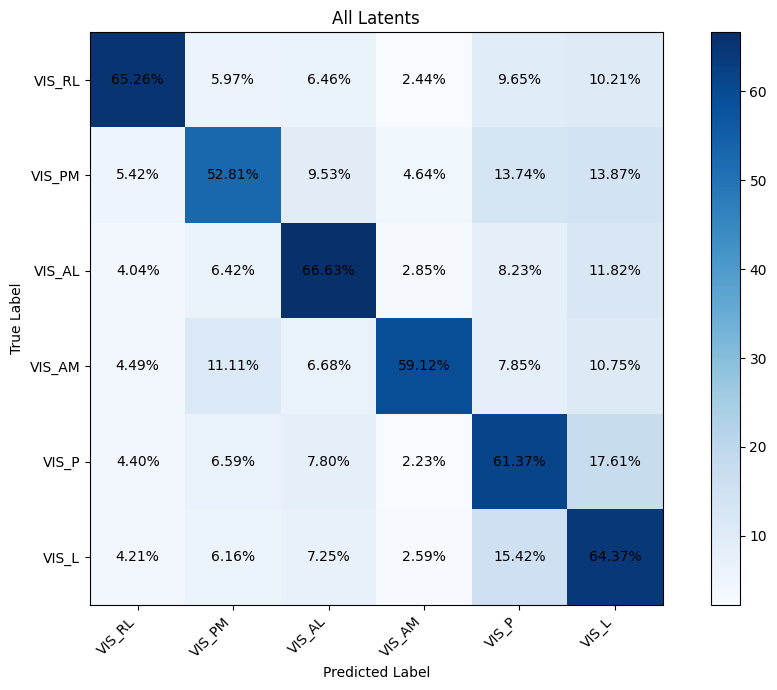

In [6]:
# Define the labels for the brain regions
labels = ['VIS_RL', 'VIS_PM', 'VIS_AL', 'VIS_AM', 'VIS_P', 'VIS_L']

# Plot the averaged confusion matrix with brain region labels
plt.figure(figsize=(10, 7))
plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('All Latents')
plt.colorbar()
plt.xticks(np.arange(num_classes), labels, rotation=45, ha='right')
plt.yticks(np.arange(num_classes), labels)

# Add percentage labels to the confusion matrix
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f'{cm_percentage[i, j]:.2f}%', ha='center', va='center', color='black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [5]:
# Assuming area_all is a tensor with the labels
area_all_np = area_all# Convert to numpy array if necessary

# Define the labels for the brain regions
labels = ['VIS_RL', 'VIS_PM', 'VIS_AL', 'VIS_AM', 'VIS_P', 'VIS_L']

# Count the occurrences of each label
unique, counts = np.unique(area_all_np, return_counts=True)

# Calculate the percentage for each label
percentages = counts / len(area_all_np) * 100

# Display the results
for label, percentage in zip(labels, percentages):
    print(f"{label}: {percentage:.2f}%")

VIS_RL: 6.85%
VIS_PM: 19.28%
VIS_AL: 10.22%
VIS_AM: 7.85%
VIS_P: 31.46%
VIS_L: 24.34%


In [6]:

# Assuming latents are in a numpy array or tensor named 'all_latents' and labels are in 'area_all'
all_latents = torch.tensor(correct_latents, dtype=torch.float32)
area_all = torch.tensor(correct_area_all, dtype=torch.long)
# Parameters
num_runs = 3
num_epochs = 50
batch_size = 256
learning_rate = 0.001

# Define the model class again for completeness
class LinearProbe(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Average tracking variables
total_val_accuracy = 0.0
total_val_loss = 0.0
total_confusion_matrix = None

# Run the process multiple times
for run in range(num_runs):
    print(f"Run {run+1}/{num_runs}")
    
    # Create a new dataset split for each run to account for randomness
    dataset = TensorDataset(all_latents, area_all)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize a new model, loss function, and optimizer for each run
    num_classes = len(torch.unique(area_all))
    input_dim = all_latents.shape[1]
    model = LinearProbe(input_dim=input_dim, output_dim=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    
    # Validation with accuracy and confusion matrix
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    val_loss /=len(val_loader)
    total_val_accuracy += accuracy
    total_val_loss += val_loss
    
    # Compute confusion matrix for this run
    cm = confusion_matrix(all_labels, all_preds)
    
    if total_confusion_matrix is None:
        total_confusion_matrix = cm
    else:
        total_confusion_matrix += cm

# Average the results over all runs
average_val_accuracy = total_val_accuracy / num_runs
average_val_loss = total_val_loss / num_runs
average_confusion_matrix = total_confusion_matrix / num_runs

# Normalize confusion matrix to percentages
cm_percentage = average_confusion_matrix / average_confusion_matrix.sum(axis=1, keepdims=True) * 100
    

Run 1/3
Epoch 1/50, Loss: 20.50209180532121
Epoch 2/50, Loss: 12.67468791887809
Epoch 3/50, Loss: 13.247201665387339
Epoch 4/50, Loss: 12.71157680720023
Epoch 5/50, Loss: 13.55354813182544
Epoch 6/50, Loss: 13.006682664223847
Epoch 7/50, Loss: 13.764130542381478
Epoch 8/50, Loss: 13.869962952946205
Epoch 9/50, Loss: 13.58473037532902
Epoch 10/50, Loss: 13.50556177430381
Epoch 11/50, Loss: 14.26172501839918
Epoch 12/50, Loss: 14.518046316090368
Epoch 13/50, Loss: 13.636113355806042
Epoch 14/50, Loss: 14.192673043400932
Epoch 15/50, Loss: 14.204039284743047
Epoch 16/50, Loss: 14.186893861766285
Epoch 17/50, Loss: 14.746188111620231
Epoch 18/50, Loss: 14.017620768796881
Epoch 19/50, Loss: 14.27630261136622
Epoch 20/50, Loss: 14.559205778638974
Epoch 21/50, Loss: 14.678781112940273
Epoch 22/50, Loss: 14.268913605761691
Epoch 23/50, Loss: 14.964689406827262
Epoch 24/50, Loss: 14.762117157764479
Epoch 25/50, Loss: 15.1228236598143
Epoch 26/50, Loss: 14.565694819821855
Epoch 27/50, Loss: 14.4

Average Validation Cross Entropy Loss: 32.1637
Average Validation Accuracy: 61.88%


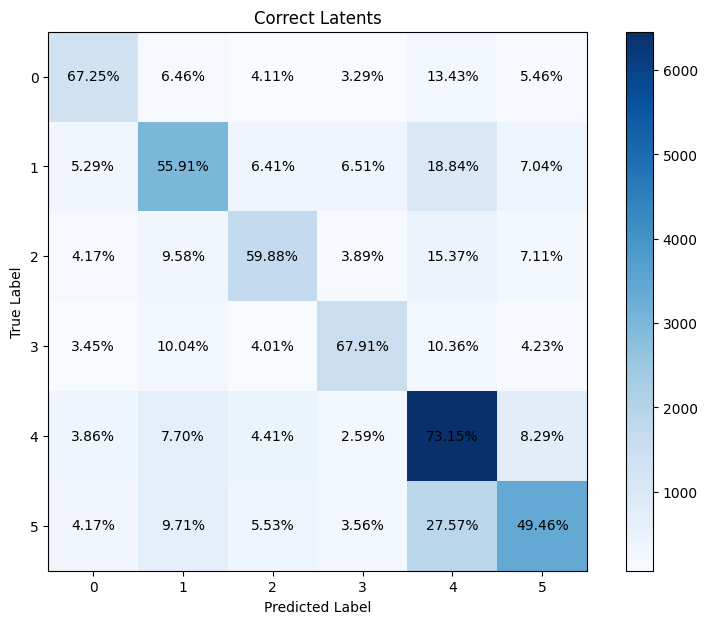

In [7]:

# Print average results
print(f"Average Validation Cross Entropy Loss: {average_val_loss:.4f}")
print(f"Average Validation Accuracy: {average_val_accuracy * 100:.2f}%")

# Plot the averaged confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(average_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Correct Latents')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add percentage labels to the confusion matrix
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f'{cm_percentage[i, j]:.2f}%', ha='center', va='center', color='black')

plt.show()

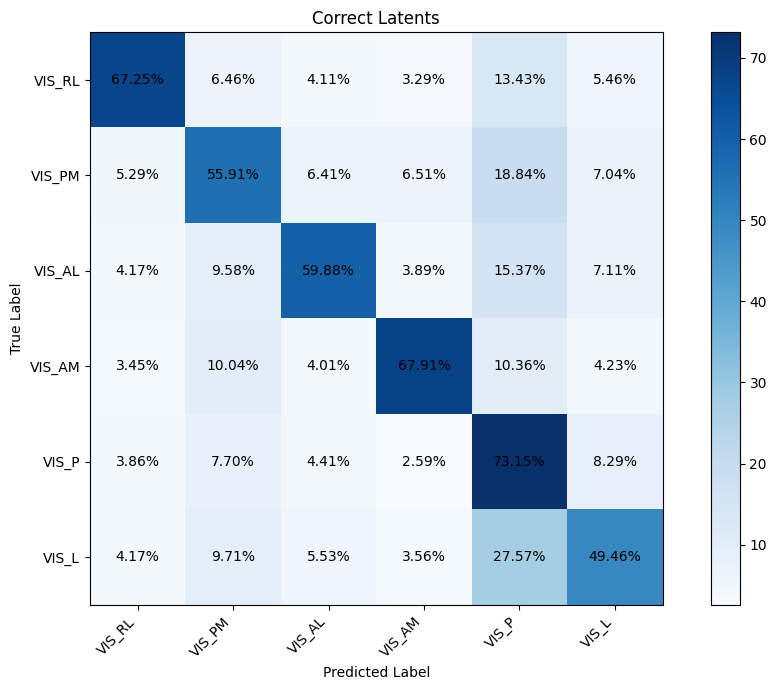

In [8]:
# Define the labels for the brain regions
labels = ['VIS_RL', 'VIS_PM', 'VIS_AL', 'VIS_AM', 'VIS_P', 'VIS_L']

# Plot the averaged confusion matrix with brain region labels
plt.figure(figsize=(10, 7))
plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Correct Latents')
plt.colorbar()
plt.xticks(np.arange(num_classes), labels, rotation=45, ha='right')
plt.yticks(np.arange(num_classes), labels)

# Add percentage labels to the confusion matrix
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f'{cm_percentage[i, j]:.2f}%', ha='center', va='center', color='black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

### Cre line probe

In [6]:

# Assuming latents are in a numpy array or tensor named 'all_latents' and labels are in 'area_all'
all_latents = torch.tensor(normalized_correct_latents, dtype=torch.float32)
area_all = torch.tensor(correct_creline_all, dtype=torch.long)
# Parameters
num_runs = 3
num_epochs = 50
batch_size = 256
learning_rate = 0.001

# Define the model class again for completeness
class LinearProbe(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Average tracking variables
total_val_accuracy = 0.0
total_val_loss = 0.0
total_confusion_matrix = None

# Run the process multiple times
for run in range(num_runs):
    print(f"Run {run+1}/{num_runs}")
    
    # Create a new dataset split for each run to account for randomness
    dataset = TensorDataset(all_latents, area_all)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize a new model, loss function, and optimizer for each run
    num_classes = len(torch.unique(area_all))
    input_dim = all_latents.shape[1]
    model = LinearProbe(input_dim=input_dim, output_dim=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    
    # Validation with accuracy and confusion matrix
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    val_loss /=len(val_loader)
    total_val_accuracy += accuracy
    total_val_loss += val_loss
    
    # Compute confusion matrix for this run
    cm = confusion_matrix(all_labels, all_preds)
    
    if total_confusion_matrix is None:
        total_confusion_matrix = cm
    else:
        total_confusion_matrix += cm

# Average the results over all runs
average_val_accuracy = total_val_accuracy / num_runs
average_val_loss = total_val_loss / num_runs
average_confusion_matrix = total_confusion_matrix / num_runs

# Normalize confusion matrix to percentages
cm_percentage = average_confusion_matrix / average_confusion_matrix.sum(axis=1, keepdims=True) * 100

# Print average results
print(f"Average Validation Cross Entropy Loss: {average_val_loss:.4f}")
print(f"Average Validation Accuracy: {average_val_accuracy * 100:.2f}%")


Run 1/3
Epoch 1/50, Loss: 0.8537894756212865
Epoch 2/50, Loss: 0.5166113719445969
Epoch 3/50, Loss: 0.4445698295204406
Epoch 4/50, Loss: 0.4002196020987691
Epoch 5/50, Loss: 0.362655615820157
Epoch 6/50, Loss: 0.3457073287567408
Epoch 7/50, Loss: 0.3323507977984761
Epoch 8/50, Loss: 0.3204443461191681
Epoch 9/50, Loss: 0.3084146525023467
Epoch 10/50, Loss: 0.3056207812796421
Epoch 11/50, Loss: 0.29356068617119063
Epoch 12/50, Loss: 0.28237258556356193
Epoch 13/50, Loss: 0.2795975933313913
Epoch 14/50, Loss: 0.2691250890832827
Epoch 15/50, Loss: 0.26935416049321853
Epoch 16/50, Loss: 0.2690328169181298
Epoch 17/50, Loss: 0.2634576419559318
Epoch 18/50, Loss: 0.2476462081991187
Epoch 19/50, Loss: 0.2608116025397881
Epoch 20/50, Loss: 0.25509996332041496
Epoch 21/50, Loss: 0.2441845238887639
Epoch 22/50, Loss: 0.23530084127242037
Epoch 23/50, Loss: 0.24024959628158388
Epoch 24/50, Loss: 0.2344627145312913
Epoch 25/50, Loss: 0.2354863633429271
Epoch 26/50, Loss: 0.2367585594670376
Epoch 27

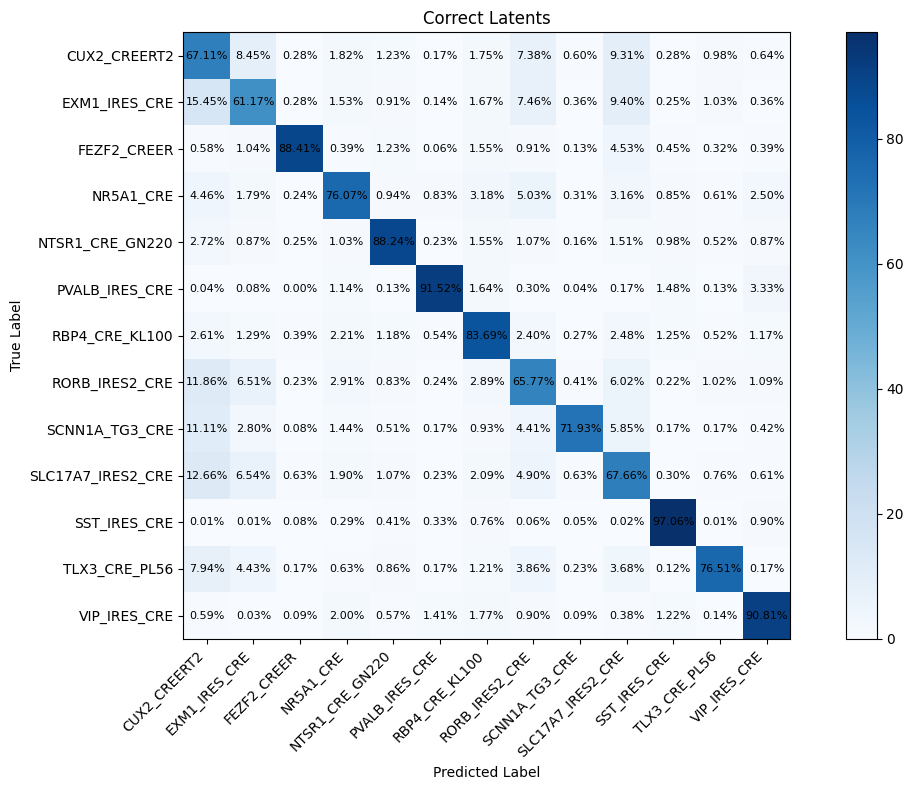

In [7]:
# Define the labels for the brain regions
labels =['CUX2_CREERT2', 'EXM1_IRES_CRE', 'FEZF2_CREER', 'NR5A1_CRE', 'NTSR1_CRE_GN220', 
 'PVALB_IRES_CRE', 'RBP4_CRE_KL100', 'RORB_IRES2_CRE', 'SCNN1A_TG3_CRE', 
 'SLC17A7_IRES2_CRE', 'SST_IRES_CRE', 'TLX3_CRE_PL56', 'VIP_IRES_CRE']
# Plot the averaged confusion matrix with brain region labels
plt.figure(figsize=(12, 8))
plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Correct Latents')
plt.colorbar()
plt.xticks(np.arange(num_classes), labels, rotation=45, ha='right',fontsize=10)
plt.yticks(np.arange(num_classes), labels, fontsize=10)

# Add percentage labels to the confusion matrix
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f'{cm_percentage[i, j]:.2f}%', ha='center', va='center', color='black', fontsize=8)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [9]:
# Assuming area_all is a tensor with the labels
area_all_np = correct_creline_all# Convert to numpy array if necessary

# Define the labels for the brain regions
#labels = ['VIS_RL', 'VIS_PM', 'VIS_AL', 'VIS_AM', 'VIS_P', 'VIS_L']

# Count the occurrences of each label
unique, counts = np.unique(area_all_np, return_counts=True)

# Calculate the percentage for each label
percentages = counts / len(area_all_np) * 100

# Display the results
for label, percentage in zip(labels, percentages):
    print(f"{label}: {percentage:.2f}%")

CUX2_CREERT2: 17.20%
EXM1_IRES_CRE: 8.88%
FEZF2_CREER: 1.80%
NR5A1_CRE: 6.41%
NTSR1_CRE_GN220: 5.27%
PVALB_IRES_CRE: 2.79%
RBP4_CRE_KL100: 10.75%
RORB_IRES2_CRE: 9.36%
SCNN1A_TG3_CRE: 1.36%
SLC17A7_IRES2_CRE: 13.67%
SST_IRES_CRE: 13.53%
TLX3_CRE_PL56: 2.12%
VIP_IRES_CRE: 6.85%


## supervised UMAP

In [6]:
import umap

In [32]:
reducer = umap.UMAP(n_components=3,n_jobs=-1, verbose=True,n_epochs=500, n_neighbors=150)
embedding = reducer.fit_transform(normalized_correct_latents, y=correct_creline_all)

UMAP(n_components=3, n_epochs=500, n_neighbors=150, verbose=True)
Tue Aug 27 16:13:14 2024 Construct fuzzy simplicial set
Tue Aug 27 16:13:20 2024 Finding Nearest Neighbors
Tue Aug 27 16:13:21 2024 Building RP forest with 16 trees
Tue Aug 27 16:13:35 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	Stopping threshold met -- exiting after 7 iterations
Tue Aug 27 16:17:29 2024 Finished Nearest Neighbor Search
Tue Aug 27 16:17:37 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Aug 27 16:18:33 2024 Finished embedding


In [16]:
# Save the numpy array to a .npz file
np.savez('/home/mila/x/xuejing.pan/scratch/latents/supervised_umap_creline.npz', su_umap_creline=embedding
         )

In [18]:
# Save the numpy array to a .npz file
np.savez('/home/mila/x/xuejing.pan/scratch/latents/supervised_umap_area.npz', su_umap_area=embedding
         )

In [19]:
import matplotlib.pyplot as plt

In [35]:
label_names = {
    0: "CUX2_CREERT2",
    1: "EXM1_IRES_CRE",
    2: "FEZF2_CREER",
    3: "NR5A1_CRE",
    4: "NTSR1_CRE_GN220",
    5: "PVALB_IRES_CRE",
    6: "RBP4_CRE_KL100",
    7: "RORB_IRES2_CRE",
    8: "SCNN1A_TG3_CRE",
    9: "SLC17A7_IRES2_CRE",
    10: "SST_IRES_CRE",
    11: "TLX3_CRE_PL56",
    12: "VIP_IRES_CRE"
}

In [14]:
depth_label_names = {
    0: "150-250 um",
    1: "250-350 um",
    2: "350-500 um",
    3: "500-600 um",
    4: "600+ um"
}

In [20]:
area_label_names = {
    0: "VIS_RL", 
    1: "VIS_PM",
    2: "VIS_AL",
    3: "VIS_AM",
    4: "VIS_P",
    5: "VIS_L"
}

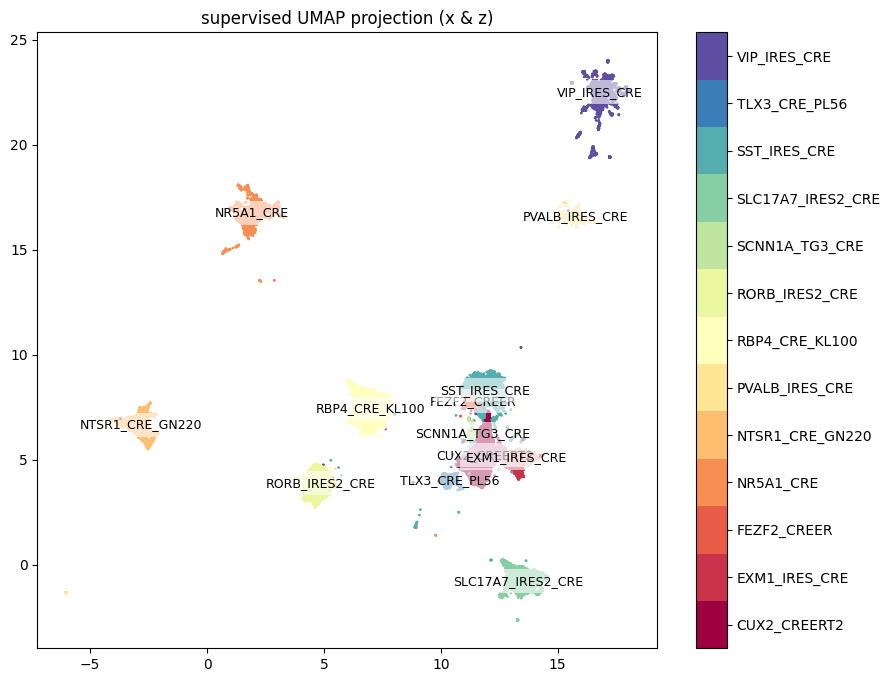

In [43]:
# Create the UMAP plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:,1], c=correct_creline_all, cmap='Spectral', s=1)

# Add a colorbar with labels
cbar = plt.colorbar(scatter, boundaries=np.arange(len(label_names) + 1) - 0.5)
cbar.set_ticks(np.arange(len(label_names)))
cbar.set_ticklabels([label_names[i] for i in range(len(label_names))])

# Annotate the plot with the cluster names
for i in range(len(label_names)):
    # Find the median point in the cluster to place the label
    cluster_indices = np.where(correct_creline_all == i)
    median_point = np.median(embedding[cluster_indices], axis=0)
    
    plt.text(median_point[0], median_point[1], label_names[i],
             fontsize=9, ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title("supervised UMAP projection (x & z)")
plt.show()

In [46]:
def create_3d_scatter_plot(normalized_all_latents_pca, session_id_all, tsne_all=False):
    if tsne_all:
        normalized_all_latents_pca = normalized_all_latents_pca[::3]
        session_id_all = session_id_all[::3]
    
    # Create DataFrame
    df = pd.DataFrame({
        'x': normalized_all_latents_pca[:, 0],
        'y': normalized_all_latents_pca[:, 1],
        'z': normalized_all_latents_pca[:, 2],
        'session': session_id_all
    })

    # Ensure that 'session' is treated as a categorical variable
    df['session'] = df['session'].astype(str)

    # Create the 3D scatter plot with smaller markers
    fig = px.scatter_3d(df, x='x', y='y', z='z', color='session', title='3D Scatter Plot of Sessions')
    fig.update_traces(marker=dict(size=1))  # Adjust the size to make markers smaller

    # Save the figure as an HTML file
    #fig.write_html("all_latent_pca_sessions.html")

    return fig

In [50]:
def create_3d_scatter_spec_plot(normalized_all_latents_pca, session_id_all, tsne_all=False):
    if tsne_all:
        normalized_all_latents_pca = normalized_all_latents_pca[::3]
        session_id_all = session_id_all[::3]
    
    # Create DataFrame
    df = pd.DataFrame({
        'x': normalized_all_latents_pca[:, 0],
        'y': normalized_all_latents_pca[:, 1],
        'z': normalized_all_latents_pca[:, 2],
        'session': session_id_all
    })

    # Ensure that 'session' is treated as a categorical variable
    df['session'] = df['session'].astype(str)
    
    # Convert 'session' to a numerical scale (spectrum) for coloring
    df['session_numeric'] = pd.factorize(df['session'])[0]
    
    # Create the 3D scatter plot with a continuous colormap
    fig = px.scatter_3d(df, x='x', y='y', z='z', 
                        color='session_numeric', 
                        color_continuous_scale='Viridis',  # Use a colormap like 'Viridis', 'Cividis', etc.
                        title='3D Scatter Plot of Sessions')

    fig.update_traces(marker=dict(size=1))  # Adjust the size to make markers smaller
    
    # Optional: Customize the colorbar to display session labels
    colorbar_ticks = {i: label for i, label in enumerate(df['session'].unique())}
    fig.update_coloraxes(colorbar=dict(tickvals=list(colorbar_ticks.keys()), ticktext=list(colorbar_ticks.values())))

    # Save the figure as an HTML file if needed
    # fig.write_html("all_latent_pca_sessions.html")

    return fig


In [51]:
#mapped_creline_names = [label_names[label] for label in correct_creline_all]
mapped_depth = [depth_label_names[label] for label in correct_depth_all]
#mapped_area = [area_label_names[label] for label in correct_area_all]
#create_3d_scatter_plot(embedding, mapped_depth).write_html("correct_UMAPsu_creline_depth.html")
create_3d_scatter_spec_plot(embedding, mapped_depth).write_html("correct_UMAPsu_creline_depth.html")

DUMP